# Visualizing and classifying EEG data

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import pandas as pd
from joblib import Memory
import re
%matplotlib inline

## Make a dataframe of file meta data

In [2]:
def pathToSeries(path):
    if 'train' in path: train = 1
    else: train = 0
    if train: 
        m = re.search('(\d).mat',path)
        preictal = int(m.group(1))
    else: preictal = -1
    m = re.search('(\d)/',path)
    patient = int(m.group(1))
    m = re.search('(.*)/(.*)',path)
    dir_name = m.group(1)
    file_name = m.group(2)
    return pd.Series({'path':path,'train':train,'preictal':preictal, 'patient':patient,
                     'dir_name': dir_name,'file_name':file_name})

base_data_dir = '../raw_data'
data_dirs = [name for name in os.listdir(base_data_dir) if os.path.isdir(os.path.join(base_data_dir, name))]
paths = [[os.path.join(data_dir, name) for name in os.listdir(os.path.join(base_data_dir,data_dir))] 
         for data_dir in data_dirs] 
paths = [j for i in paths for j in i] # flatten to 1d
paths = [i for i in paths if '.DS_Store' not in i]
    
files_df = pd.DataFrame([pathToSeries(p) for p in paths])
files_df.head(5)

,dir_name,file_name,path,patient,preictal,train
0,test_1,1_1.mat,test_1/1_1.mat,1,-1,0
1,test_1,1_10.mat,test_1/1_10.mat,1,-1,0
2,test_1,1_100.mat,test_1/1_100.mat,1,-1,0
3,test_1,1_1000.mat,test_1/1_1000.mat,1,-1,0
4,test_1,1_1001.mat,test_1/1_1001.mat,1,-1,0


## Accessing the data

In [3]:
def matToArr(path):
    try: 
        mat = loadmat(path)
        return mat['dataStruct']['data'][0][0].transpose()
    except:
        return None
    
df = pd.DataFrame()
example = matToArr(os.path.join(base_data_dir,paths[0]))
example.shape

(16, 240000)

In [4]:
def getPath(patient,train,preictal,sample):
    path = files_df[(files_df.patient==patient) &
                   (files_df.train==train) &
                   (files_df.preictal==preictal)
                   ].iloc[sample]['path']
    return os.path.join(base_data_dir,path)

interictal_example = matToArr(getPath(1,1,0,0)) 
preictal_example =  matToArr(getPath(1,1,1,0)) 
test_example =  matToArr(getPath(1,0,-1,0)) 
print(interictal_example.shape)

(16, 240000)


## Plotting the data

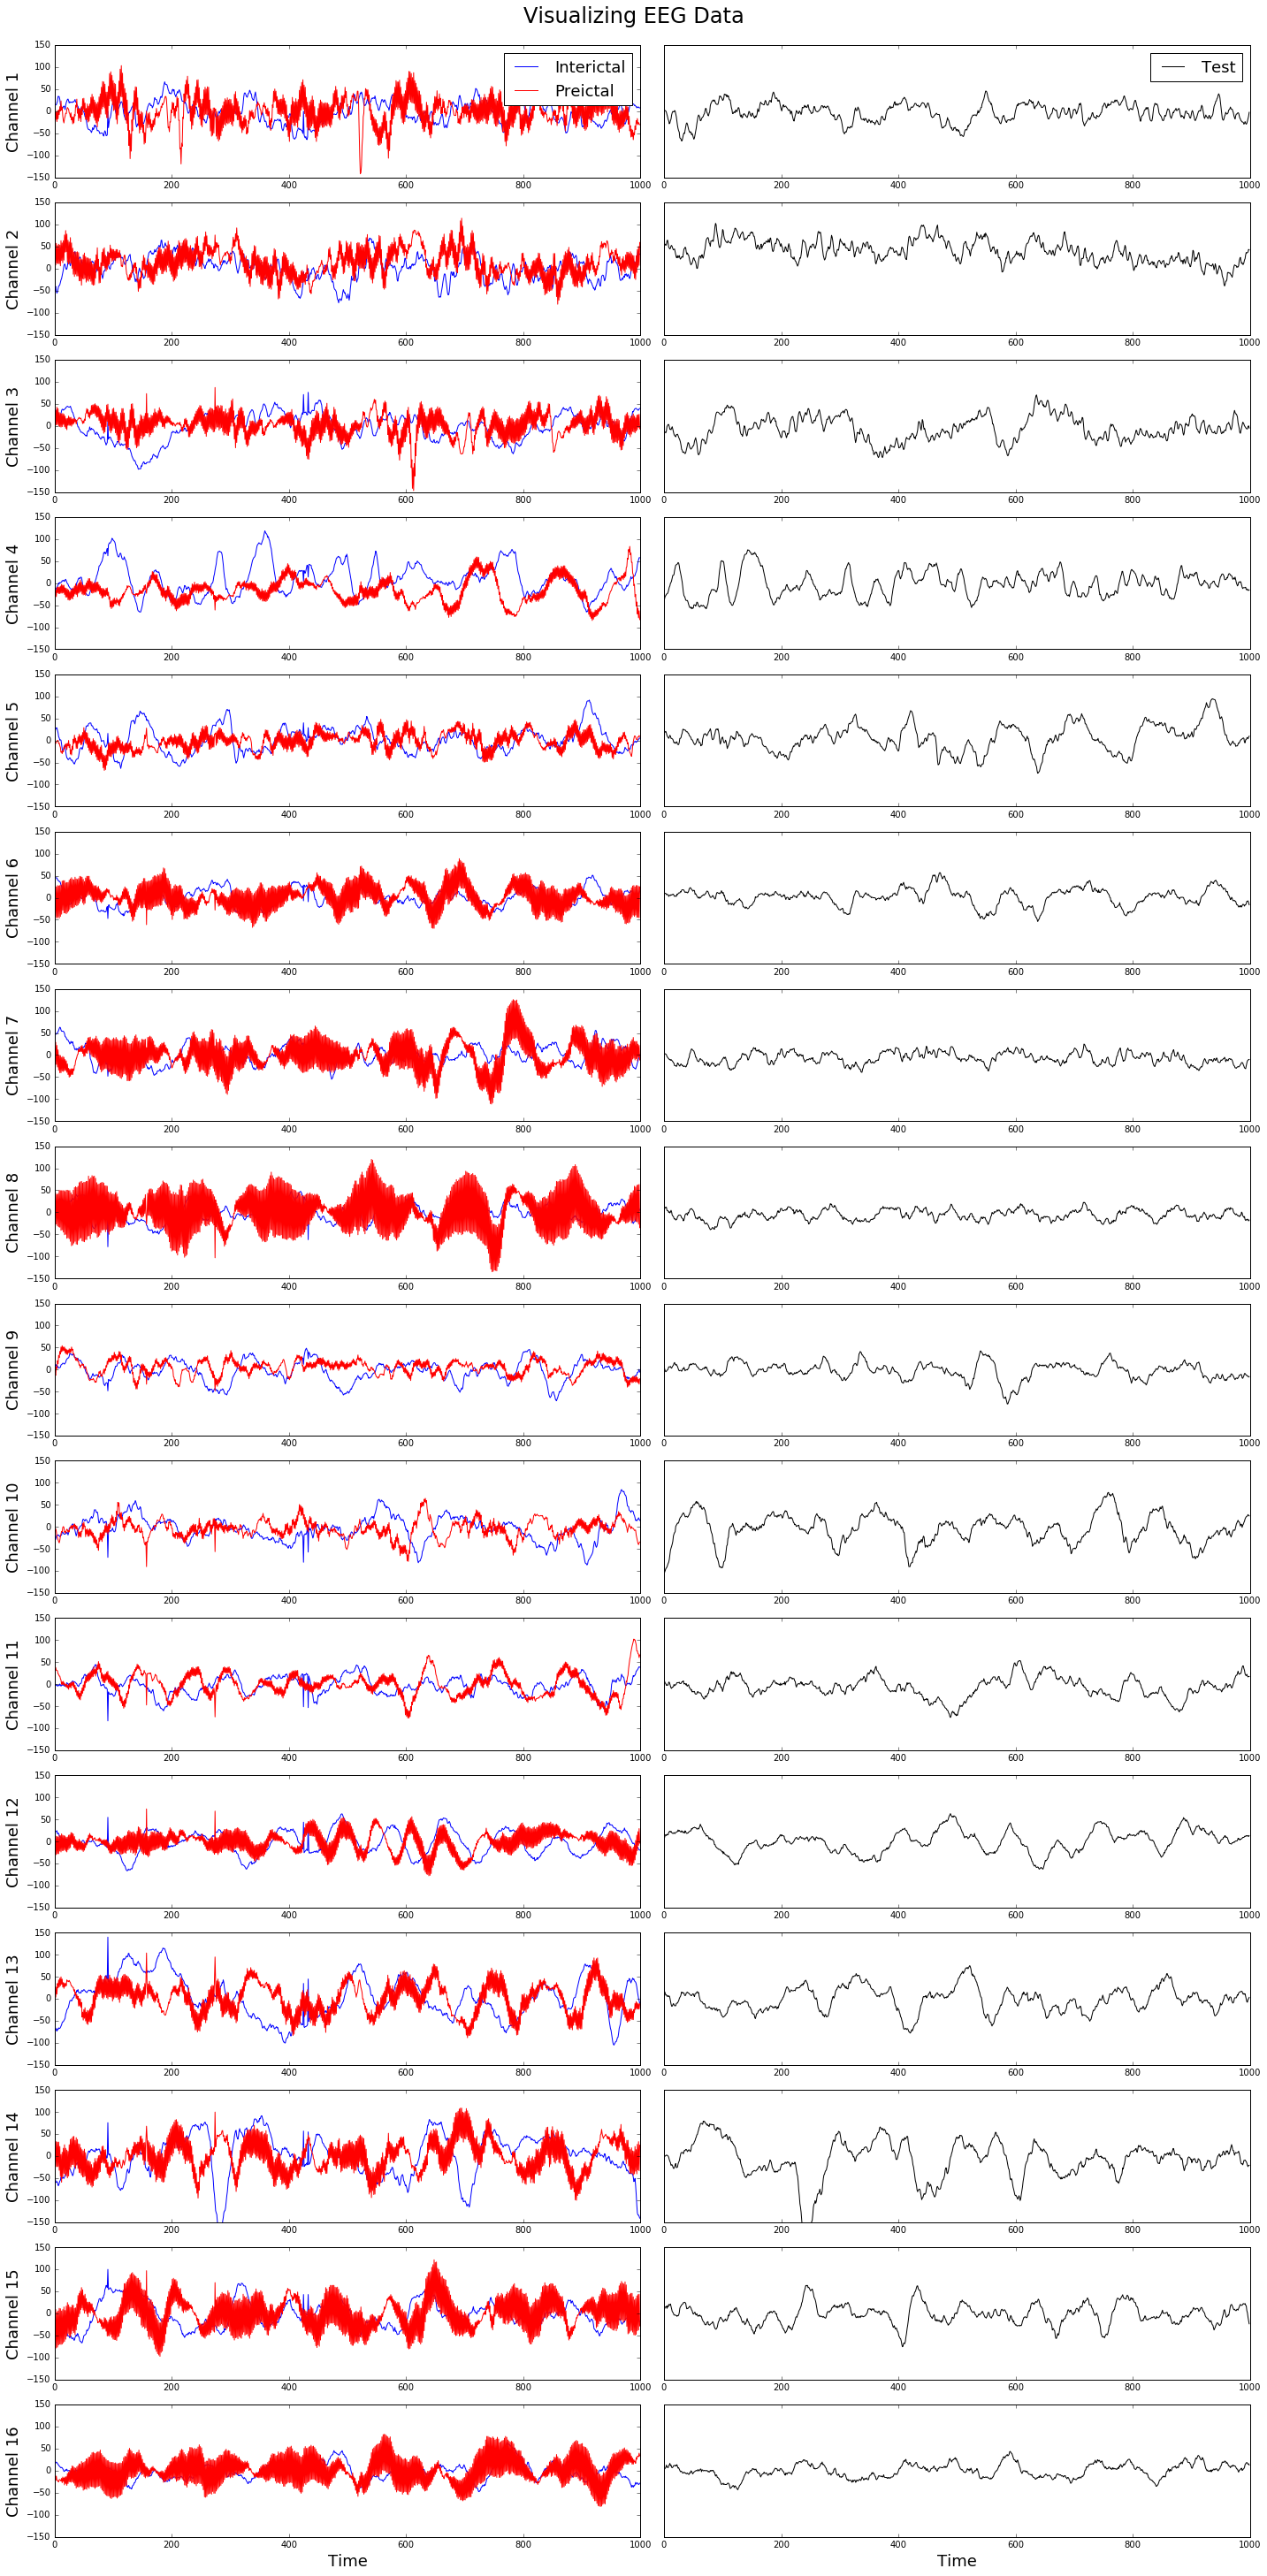

In [5]:
number_of_samples = 1000
time = np.arange(number_of_samples)
assert interictal_example.shape[0] == preictal_example.shape[0]
assert test_example.shape[0] == preictal_example.shape[0]
number_of_channels = interictal_example.shape[0]

fig, axs = plt.subplots(number_of_channels, 2, figsize=(20, 40))
for i in range(16):
    # Left columns
    interictal_channel = interictal_example[i,:number_of_samples]
    preictal_channel = preictal_example[i,:number_of_samples]
    interictal_line, = axs[i][0].plot(time, interictal_channel, color='blue')
    preictal_line, = axs[i][0].plot(time, preictal_channel, color='red')
    axs[i][0].set_ylim([-150, 150])
    axs[i][0].set_ylabel('Channel %d' % (i+1), fontsize=18)
    
    # Right column
    test_channel = test_example[i,:number_of_samples]
    test_line, = axs[i][1].plot(time, test_channel, color='black')
    axs[i][1].set_ylim([-150, 150])
    axs[i][1].yaxis.set_visible(False)
axs[0][0].legend((interictal_line, preictal_line), ('Interictal', 'Preictal'), fontsize=18)
axs[0][1].legend((test_line,), ('Test',), fontsize=18)

axs[number_of_channels-1][0].set_xlabel('Time', fontsize=18)
axs[number_of_channels-1][1].set_xlabel('Time', fontsize=18)
fig.suptitle('Visualizing EEG Data', y=1.01, fontsize=24)
plt.tight_layout()
plt.show()

## Computer frequency power features on subset of data.

In [128]:
%%time
mem = Memory(cachedir='../cache', verbose=0)

@mem.cache
def extract_pib_features(path,bins):
    samples = matToArr(path)
    freq_data = np.abs(np.fft.fft(samples))
    max_power = np.max(freq_data)
    if max_power == 0: max_power = 1 # avoids divide by zero error if all data missing
    pib, _ = np.histogram(freq_data/max_power, bins=bins)
    return pib[:-1]

bins = np.array([0, .001, .005, .01, 1])
number_of_samples = 24
interictal_features = np.zeros((number_of_samples, 3))
preictal_features = np.zeros((number_of_samples, 3))
for i in range(number_of_samples):
    interictal_features[i,:] = extract_pib_features(getPath(1,1,0,i),bins)
    preictal_features[i,:] = extract_pib_features(getPath(1,1,1,i),bins)

CPU times: user 191 ms, sys: 7.74 ms, total: 199 ms
Wall time: 198 ms


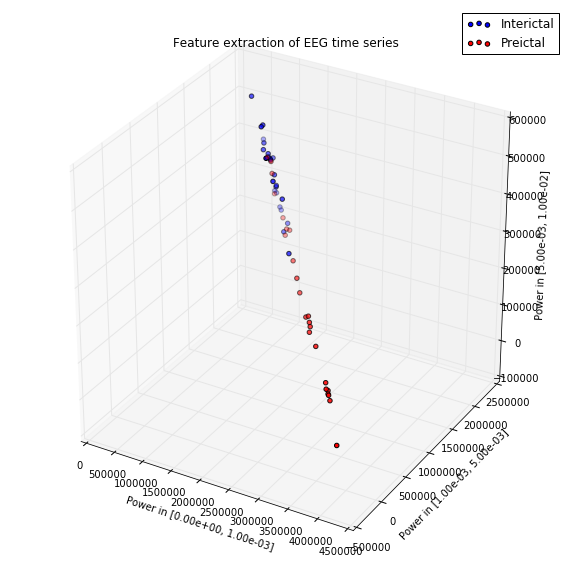

In [129]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.scatter(interictal_features[:,0],
           interictal_features[:,1],
           interictal_features[:,2], c='blue', label='Interictal')
ax.scatter(preictal_features[:,0],
           preictal_features[:,1],
           preictal_features[:,2], c='red', label='Preictal')
ax.set_xlabel('Power in [%.2e, %.2e]' % (bins[0], bins[1]))
ax.set_ylabel('Power in [%.2e, %.2e]' % (bins[1], bins[2]))
ax.set_zlabel('Power in [%.2e, %.2e]' % (bins[2], bins[3]))
ax.set_title('Feature extraction of EEG time series')
ax.legend()
plt.show()